In [4]:
# External library imports for image processing and manipulation
import cv2
import matplotlib.pyplot as plt
import numpy as np

# PyTorch related imports
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import IterableDataset

import scribbles
import visualize

In [5]:
#Load RbG image
file_path = '2023-12-25_10_26.jpg' 
rgb_image = cv2.imread(file_path, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

#Loag Mask
file_path = '2023-12-25_10_26.png' 
gray_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

In [6]:
# Define your parameters here
border_scribble_max_chunk_length = 200
border_scribble_min_chunk_length = 10
border_scribble_border_margin = 5
border_scribble_epsilon = 2
border_scribble_thicknes = 3
border_scribble_inclusion_probability = 1
border_scribble_erode_iterations = 0

# Generate scribbles for all classes
border_sribbles = scribbles.generate_border_multiclass_scribbles(gray_image, border_scribble_max_chunk_length, border_scribble_min_chunk_length, border_scribble_border_margin, border_scribble_epsilon, border_scribble_inclusion_probability, border_scribble_thicknes,border_scribble_erode_iterations)

# Now scribbles_image will contain the scribbles where the pixel values correspond to the class labels

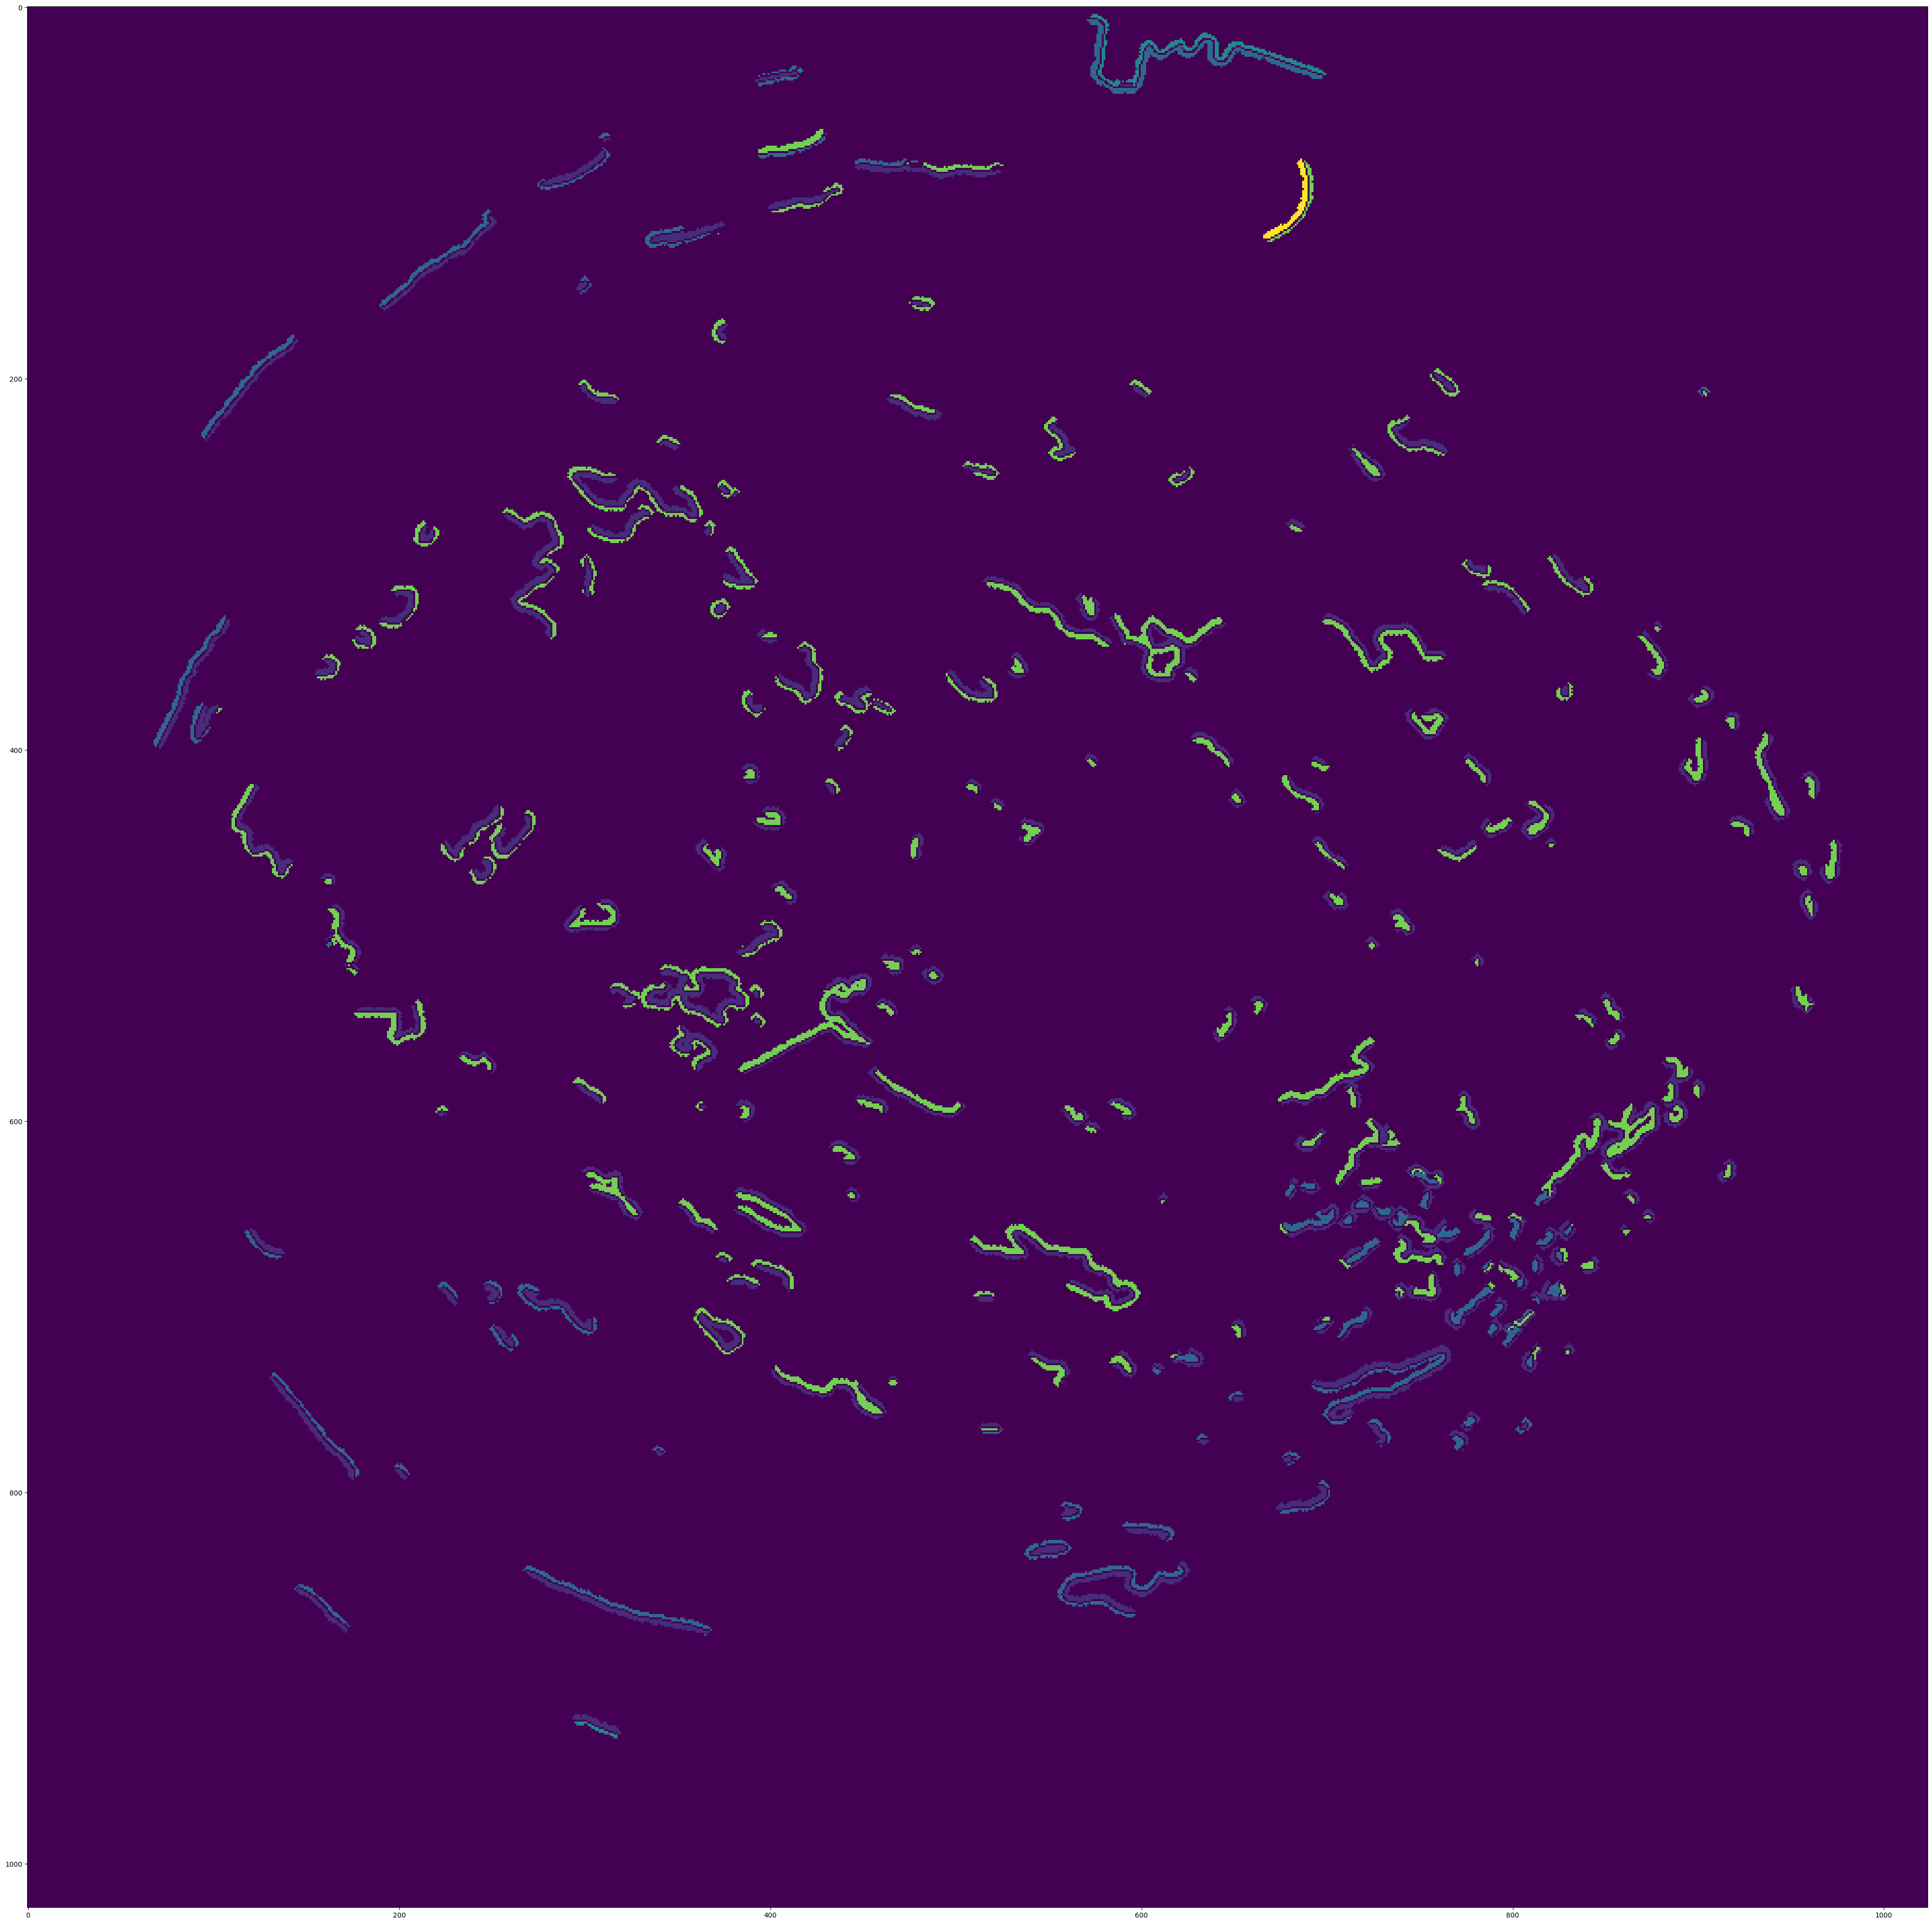

In [7]:
plt.figure(figsize=(50, 50))
    
plt.imshow(border_sribbles)

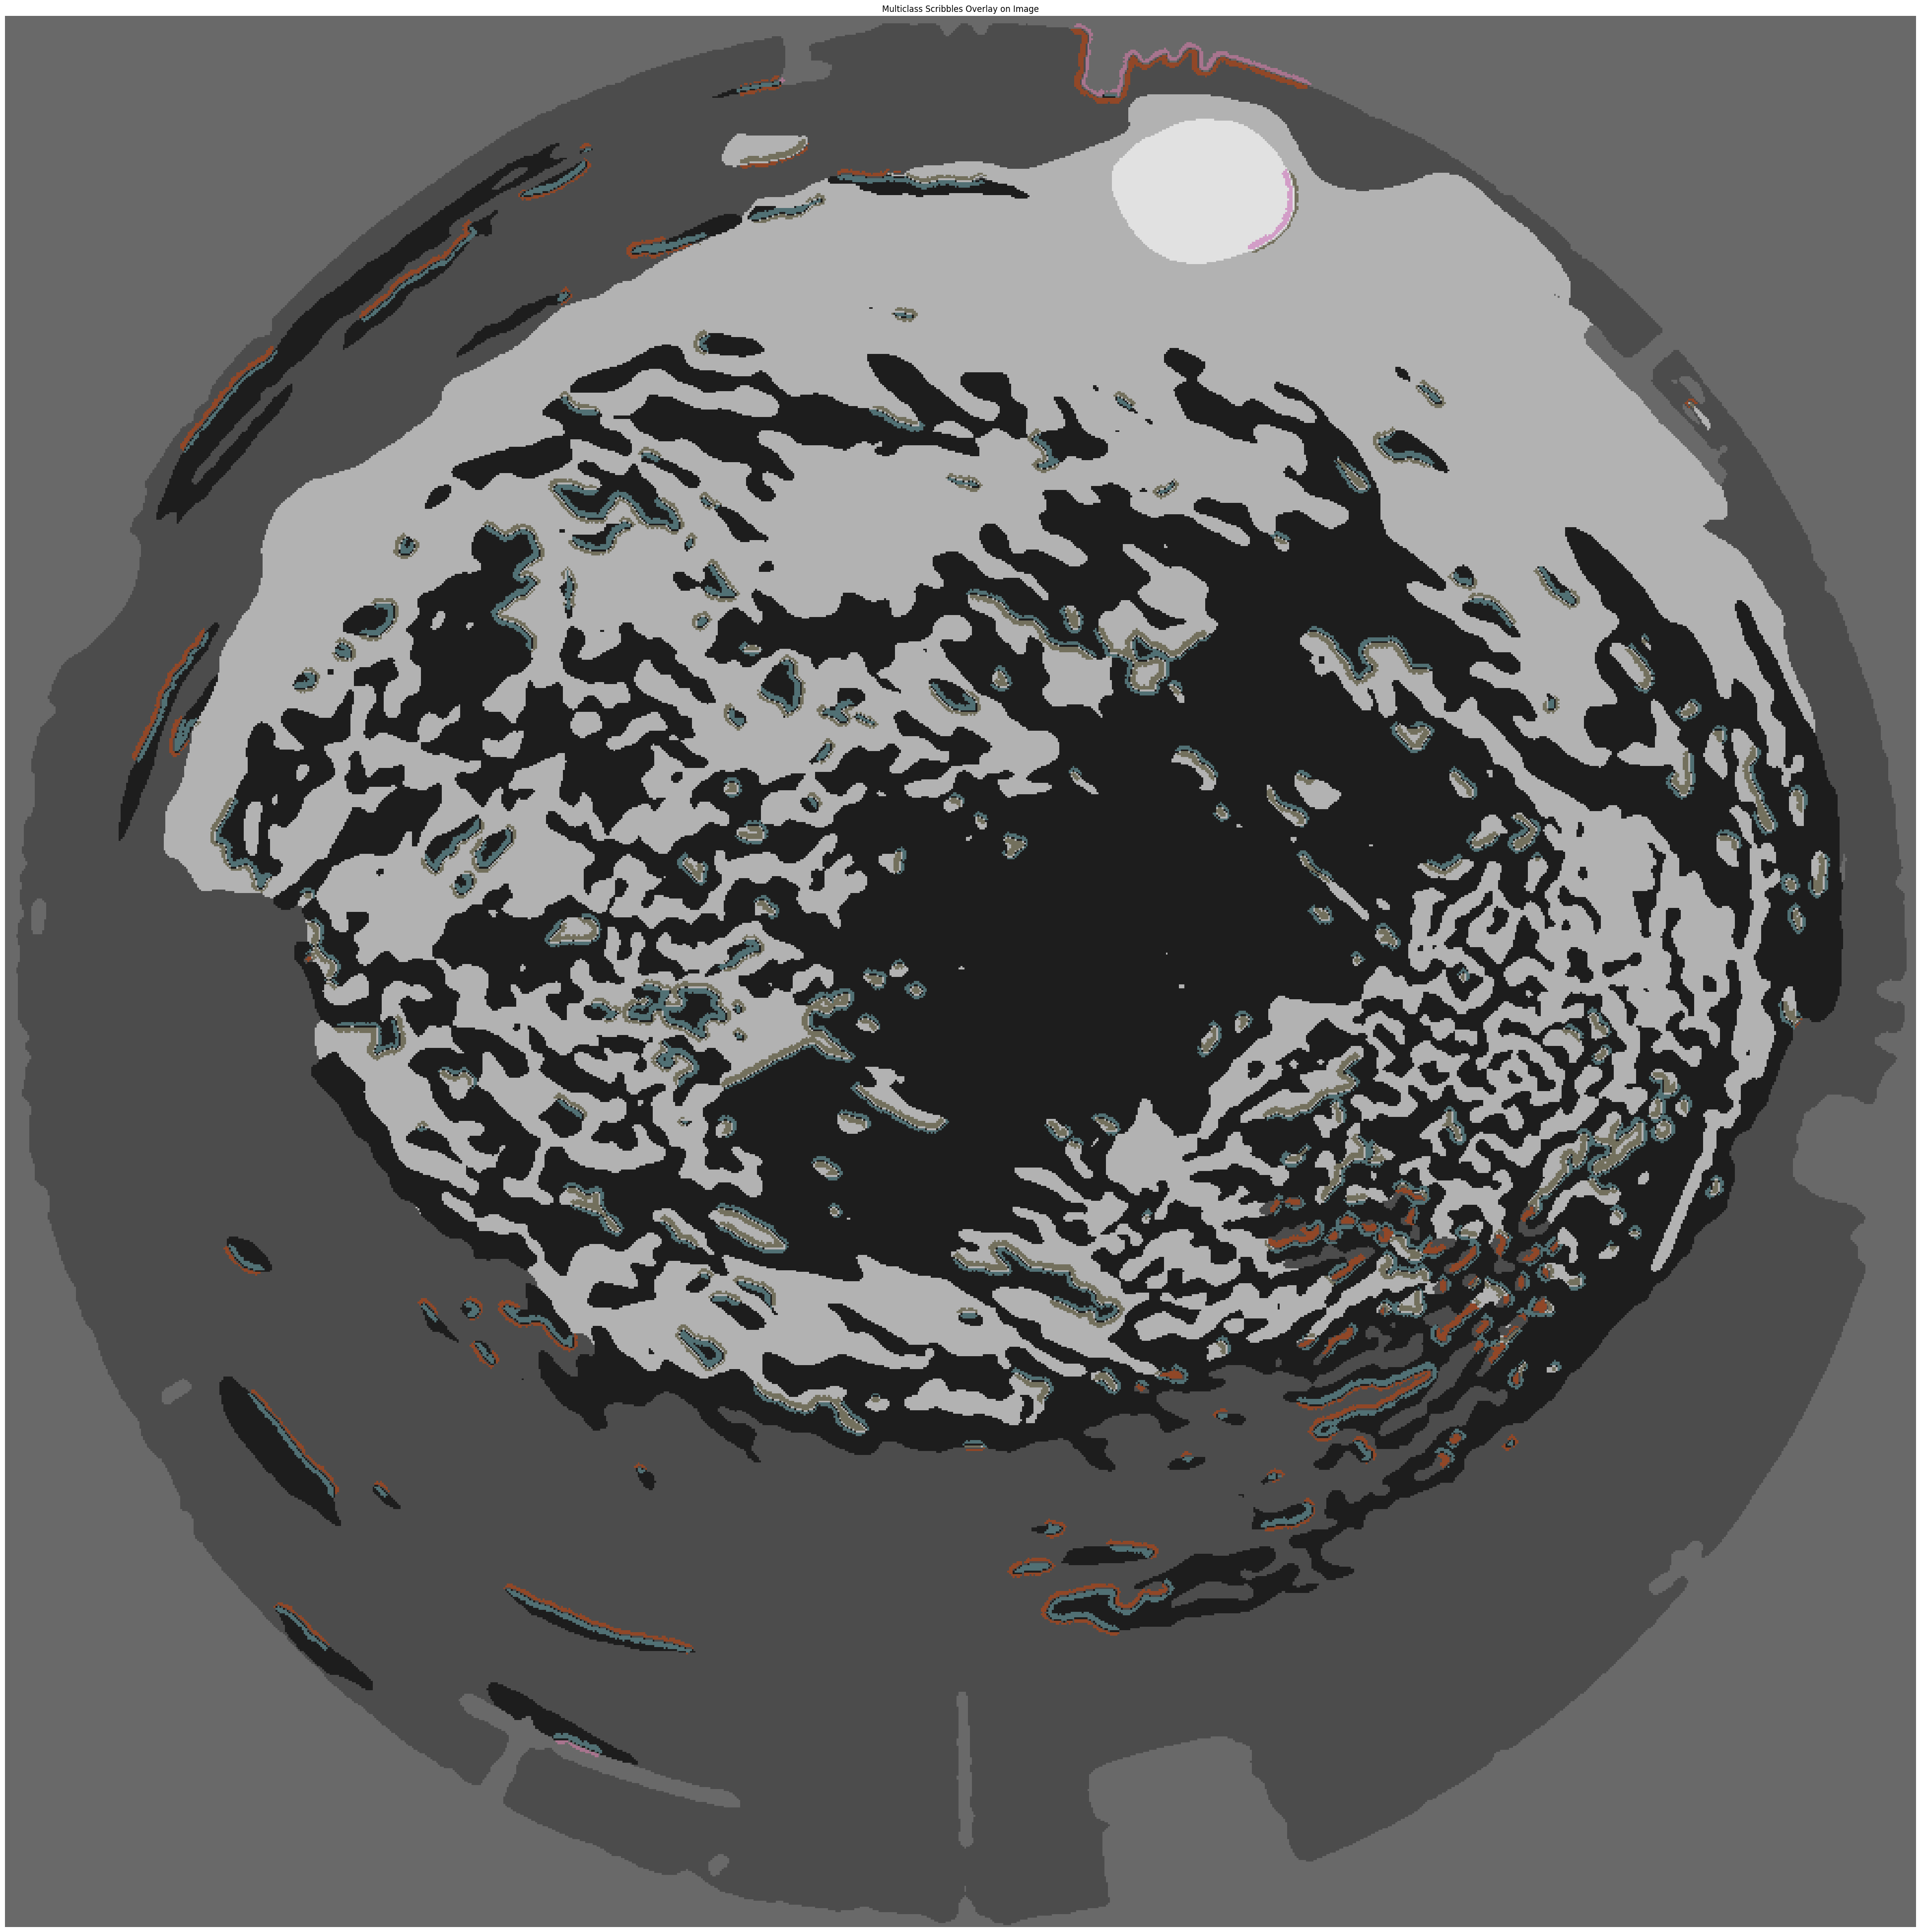

In [8]:
# Plot the overlayed multiclass scribbles on the grayscale image, works with etier the mask or the RGB
visualize.plot_overlay_multiclass_scribbles(gray_image, border_sribbles,plot_size=(50,50))

In [9]:
# Define parameters
intern_scribble_num_scribbles_per_contour = 1  
intern_scribble_max_scribble_length = 30        
intern_scribble_thickness_range = (2, 5)       
intern_scribble_scribble_density=0.01
intern_scribble_edge_thickness = 10
 # Maximum length of each small scribble

# Generate internal scribbles
internal_scribbles = scribbles.generate_scribbles_inside_contours(gray_image, intern_scribble_num_scribbles_per_contour, intern_scribble_max_scribble_length, intern_scribble_thickness_range, intern_scribble_edge_thickness)


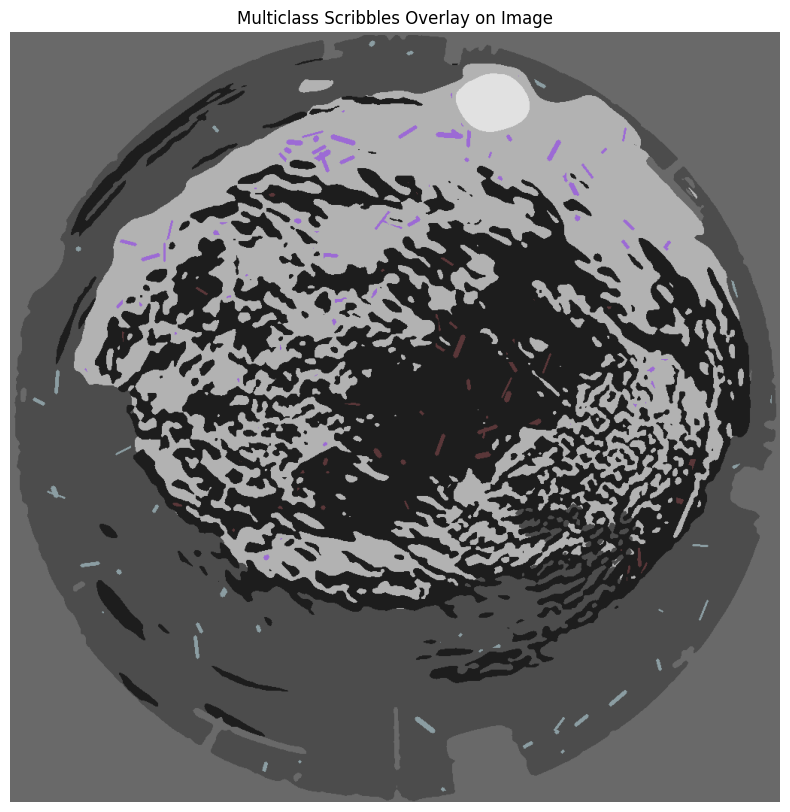

In [10]:
visualize.plot_overlay_multiclass_scribbles(gray_image, internal_scribbles,plot_size=(10,10))

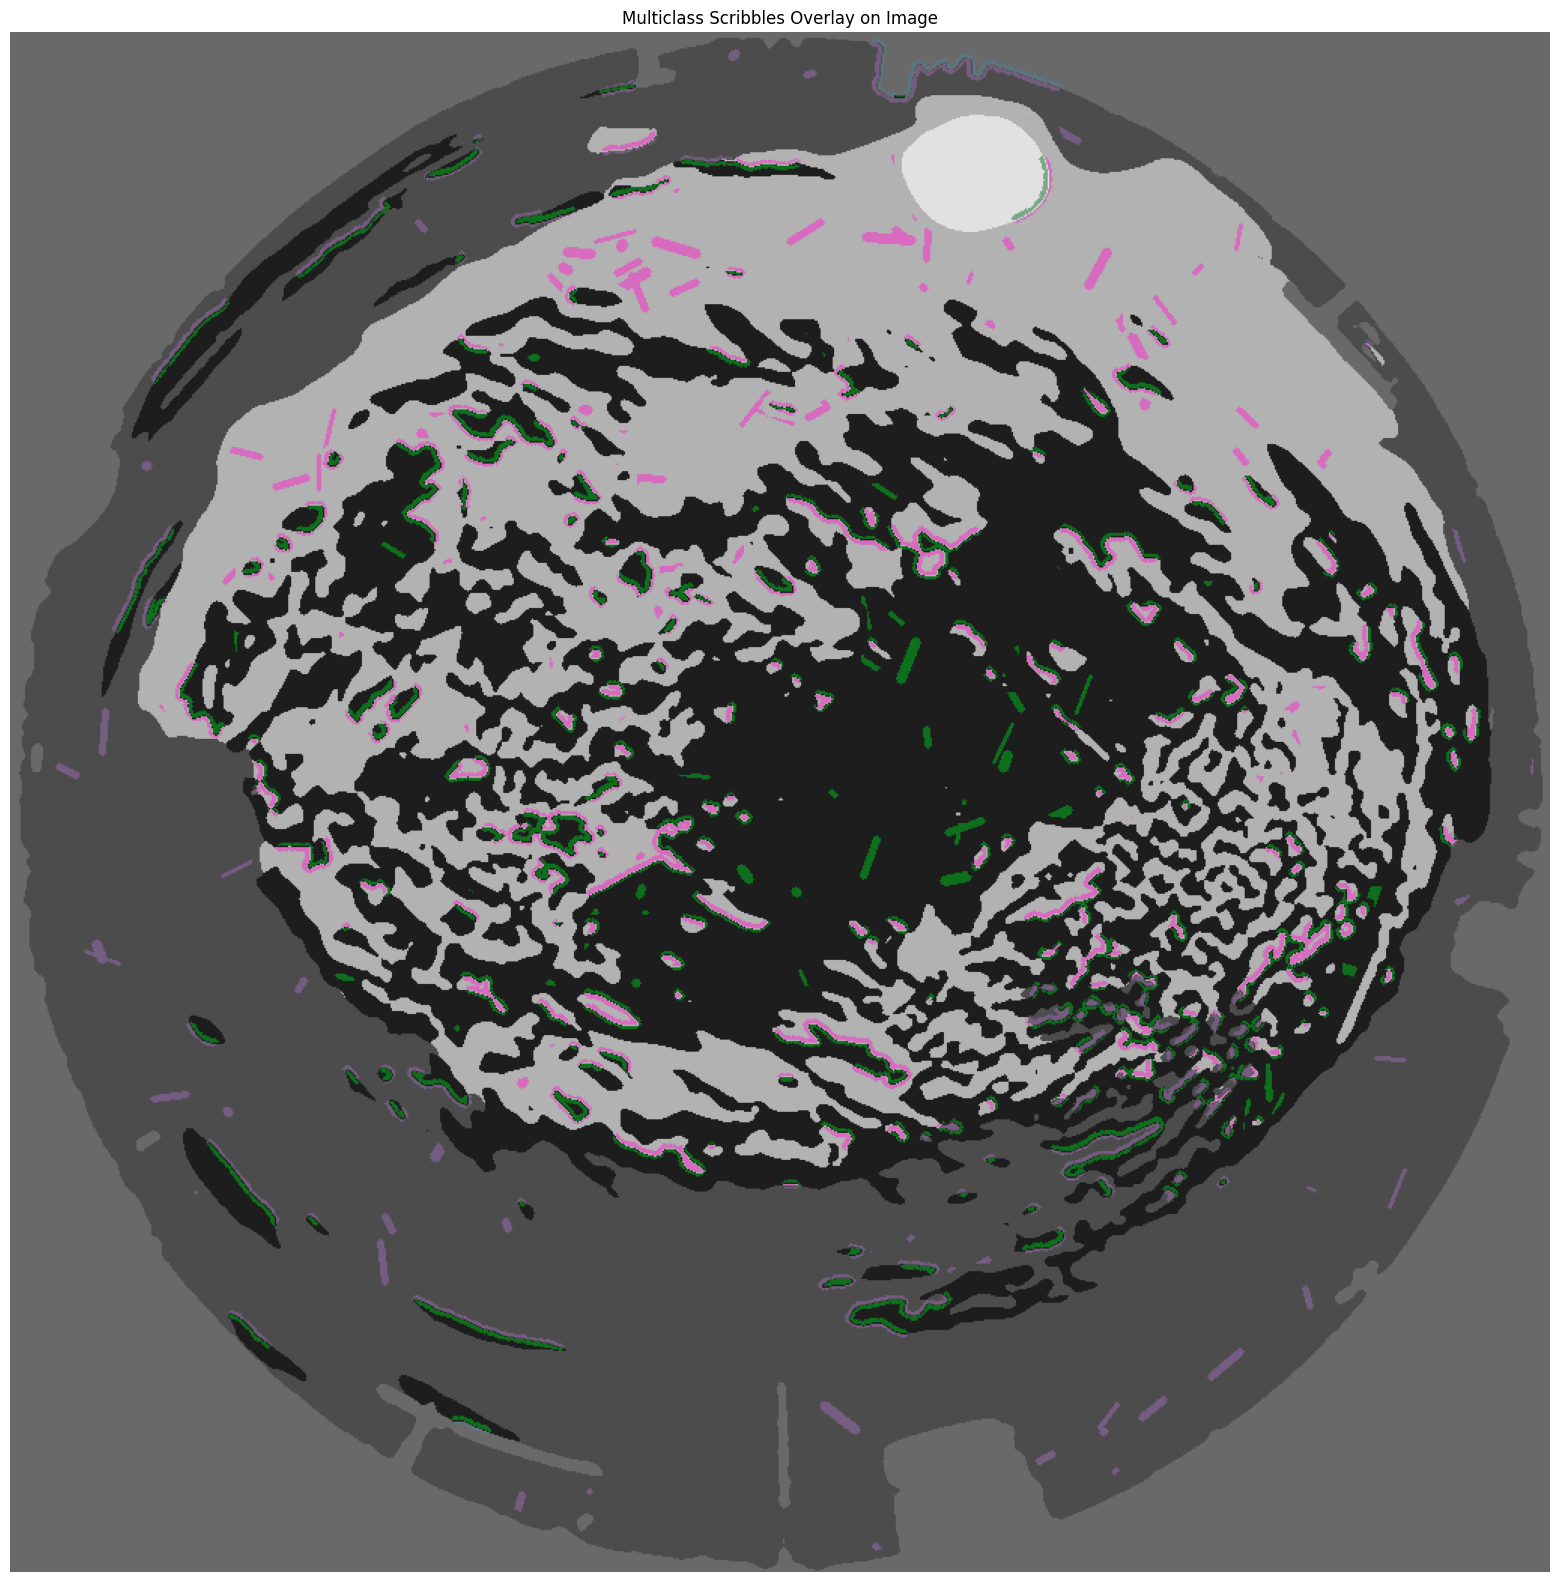

In [11]:
combined_scribbles = np.maximum(border_sribbles, internal_scribbles)
visualize.plot_overlay_multiclass_scribbles(gray_image, combined_scribbles)

In [12]:
class CustomScribbleDataset(IterableDataset):
    def __init__(self, image_paths, mask_paths, n_binary, n_subclasses, border_scribble_params, internal_scribble_params):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_binary = n_binary
        self.n_subclasses = n_subclasses
        self.border_scribble_params = border_scribble_params
        self.internal_scribble_params = internal_scribble_params
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __iter__(self):
        for idx in range(len(self.image_paths)):
            # Load image and mask
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

            # Normalize and convert the image to tensor
            image_tensor = transforms.ToTensor()(image)
            image_tensor = self.normalize(image_tensor)

            unique_classes = np.unique(mask)
            unique_classes = unique_classes[unique_classes != 0]
            
            # Binary classification for random classes
            if self.n_binary > 0 and len(unique_classes) > 1:
                for _ in range(self.n_binary):
                    cls = np.random.choice(unique_classes)
                    binary_mask = np.where(mask == cls, cls, 0)
                    print(np.unique(binary_mask))
                    binary_mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(binary_mask_tensor)
                    yield image_tensor, scribble_mask_tensor,binary_mask_tensor
            
            # Generate multiclass scenarios
            if self.n_subclasses > 0 and len(unique_classes) > 1:
                n_subclasses = len(unique_classes) if len(unique_classes) <= self.n_subclasses else self.n_subclasses
                for _ in range(self.n_subclasses):
                    num_classes = np.random.randint(2, len(unique_classes))
                    selected_classes = np.random.choice(unique_classes, num_classes, replace=False)
                    print(selected_classes)

                    # Create a multiclass mask with original class labels
                    sub_mask = np.zeros_like(mask)
                    for cls in selected_classes:
                        sub_mask[mask == cls] = cls

                    sub_mask_tensor = torch.tensor(sub_mask, dtype=torch.int64).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(sub_mask_tensor)
                    yield image_tensor, scribble_mask_tensor, sub_mask_tensor

    def _generate_scribble_mask(self, mask_tensor):
        # Convert tensor to numpy array and remove channel dimension
        mask = mask_tensor.squeeze().numpy().astype(np.uint8)

        # Generate scribbles inside contours
        internal_scribbles = scribbles.generate_scribbles_inside_contours(mask, **self.internal_scribble_params)

        # Generate border scribbles
        border_scribbles = scribbles.generate_border_multiclass_scribbles(mask, **self.border_scribble_params)

        # Combine scribbles
        combined_scribbles = np.maximum(internal_scribbles, border_scribbles)

        # Convert combined scribbles to tensor
        scribble_tensor = torch.tensor(combined_scribbles, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return scribble_tensor

In [13]:
import os
import shutil
import cv2
import numpy as np
import torch
from torchvision import transforms
import scribbles

class CustomScribbleGenerator:
    def __init__(self, image_paths, mask_paths, output_dir, n_binary, n_subclasses, border_scribble_params, internal_scribble_params):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.output_dir = output_dir
        self.n_binary = n_binary
        self.n_subclasses = n_subclasses
        self.border_scribble_params = border_scribble_params
        self.internal_scribble_params = internal_scribble_params
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def generate_and_save(self):
        rgb_dir = os.path.join(self.output_dir, "rgb")
        os.makedirs(rgb_dir, exist_ok=True)

        for idx in range(len(self.image_paths)):
            # Load image and mask
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

            # Move the original RGB image to the rgb folder
            rgb_name = os.path.basename(self.image_paths[idx])
            rgb_path = os.path.join(rgb_dir, rgb_name)
            shutil.copy(self.image_paths[idx], rgb_path)

            # Normalize and convert the image to tensor
            image_tensor = transforms.ToTensor()(image)
            image_tensor = self.normalize(image_tensor)

            unique_classes = np.unique(mask)
            unique_classes = unique_classes[unique_classes != 0]
            
            # Binary classification for random classes
            if self.n_binary > 0 and len(unique_classes) > 1:
                for i in range(self.n_binary):
                    cls = np.random.choice(unique_classes)
                    binary_mask = np.where(mask == cls, cls, 0)
                    binary_mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(binary_mask_tensor)
                    self._save_files(rgb_name, scribble_mask_tensor, binary_mask_tensor, 1, idx, i)
            
            # Generate multiclass scenarios
            if self.n_subclasses > 0 and len(unique_classes) > 1:
                n_subclasses = len(unique_classes) if len(unique_classes) <= self.n_subclasses else self.n_subclasses
                for i in range(self.n_subclasses):
                    num_classes = np.random.randint(2, len(unique_classes))
                    selected_classes = np.random.choice(unique_classes, num_classes, replace=False)

                    # Create a multiclass mask with original class labels
                    sub_mask = np.zeros_like(mask)
                    for cls in selected_classes:
                        sub_mask[mask == cls] = cls

                    sub_mask_tensor = torch.tensor(sub_mask, dtype=torch.int64).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(sub_mask_tensor)
                    self._save_files(rgb_name, scribble_mask_tensor, sub_mask_tensor, num_classes, idx, i)

    def _generate_scribble_mask(self, mask_tensor):
        # Convert tensor to numpy array and remove channel dimension
        mask = mask_tensor.squeeze().numpy().astype(np.uint8)

        # Generate scribbles inside contours
        internal_scribbles = scribbles.generate_scribbles_inside_contours(mask, **self.internal_scribble_params)

        # Generate border scribbles
        border_scribbles = scribbles.generate_border_multiclass_scribbles(mask, **self.border_scribble_params)

        # Combine scribbles
        combined_scribbles = np.maximum(internal_scribbles, border_scribbles)

        # Convert combined scribbles to tensor
        scribble_tensor = torch.tensor(combined_scribbles, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return scribble_tensor

    def _save_files(self, rgb_name, scribble_mask_tensor, mask_tensor, num_classes, idx, i):
        # Create directory for the number of classes if it doesn't exist
        class_dir = os.path.join(self.output_dir, f"{num_classes}_classes")
        os.makedirs(class_dir, exist_ok=True)

        # Create subfolders for scribble and mask
        scr_dir = os.path.join(class_dir, "scribble")
        msk_dir = os.path.join(class_dir, "mask")
        os.makedirs(scr_dir, exist_ok=True)
        os.makedirs(msk_dir, exist_ok=True)

        # Save scribble mask
        scr_name = f"{os.path.splitext(rgb_name)[0]}_scr_{idx}_{i}.png"
        scr_path = os.path.join(scr_dir, scr_name)
        scr_image = transforms.ToPILImage()(scribble_mask_tensor)
        scr_image.save(scr_path)

        # Save ground truth mask
        msk_name = f"{os.path.splitext(rgb_name)[0]}_msk_{idx}_{i}.png"
        msk_path = os.path.join(msk_dir, msk_name)
        msk_image = transforms.ToPILImage()(mask_tensor.to(torch.uint8))
        msk_image.save(msk_path)


In [14]:
import os
import shutil
import cv2
import numpy as np
import torch
from torchvision import transforms
import scribbles

class CustomScribbleGenerator:
    def __init__(self, image_paths, mask_paths, output_dir, n_binary, n_subclasses, border_scribble_params, internal_scribble_params, patch_size=None, patch_images=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.output_dir = output_dir
        self.n_binary = n_binary
        self.n_subclasses = n_subclasses
        self.border_scribble_params = border_scribble_params
        self.internal_scribble_params = internal_scribble_params
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.patch_size = patch_size
        self.patch_images = patch_images

    def generate_and_save(self):
        rgb_dir = os.path.join(self.output_dir, "rgb")
        os.makedirs(rgb_dir, exist_ok=True)

        for idx in range(len(self.image_paths)):
            # Load image and mask
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

            # Move the original RGB image to the rgb folder
            rgb_name = os.path.basename(self.image_paths[idx])
            rgb_path = os.path.join(rgb_dir, rgb_name)
            shutil.copy(self.image_paths[idx], rgb_path)

            # Normalize and convert the image to tensor
            image_tensor = transforms.ToTensor()(image)
            image_tensor = self.normalize(image_tensor)

            unique_classes = np.unique(mask)
            unique_classes = unique_classes[unique_classes != 0]
            
            # Binary classification for random classes
            if self.n_binary > 0 and len(unique_classes) > 1:
                for i in range(self.n_binary):
                    cls = np.random.choice(unique_classes)
                    binary_mask = np.where(mask == cls, cls, 0)
                    binary_mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(binary_mask_tensor)
                    self._save_files(rgb_name, scribble_mask_tensor, binary_mask_tensor, 1, idx, i)
            
            # Generate multiclass scenarios
            if self.n_subclasses > 0 and len(unique_classes) > 1:
                n_subclasses = len(unique_classes) if len(unique_classes) <= self.n_subclasses else self.n_subclasses
                for i in range(self.n_subclasses):
                    num_classes = np.random.randint(2, len(unique_classes))
                    selected_classes = np.random.choice(unique_classes, num_classes, replace=False)

                    # Create a multiclass mask with original class labels
                    sub_mask = np.zeros_like(mask)
                    for cls in selected_classes:
                        sub_mask[mask == cls] = cls

                    sub_mask_tensor = torch.tensor(sub_mask, dtype=torch.int64).unsqueeze(0)
                    scribble_mask_tensor = self._generate_scribble_mask(sub_mask_tensor)
                    self._save_files(rgb_name, scribble_mask_tensor, sub_mask_tensor, num_classes, idx, i)

            # Patch and save images if chosen
            if self.patch_images and self.patch_size is not None:
                self._patch_and_save_images(image, mask, rgb_name, idx)

    def _generate_scribble_mask(self, mask_tensor):
        # Convert tensor to numpy array and remove channel dimension
        mask = mask_tensor.squeeze().numpy().astype(np.uint8)

        # Generate scribbles inside contours
        internal_scribbles = scribbles.generate_scribbles_inside_contours(mask, **self.internal_scribble_params)

        # Generate border scribbles
        border_scribbles = scribbles.generate_border_multiclass_scribbles(mask, **self.border_scribble_params)

        # Combine scribbles
        combined_scribbles = np.maximum(internal_scribbles, border_scribbles)

        # Convert combined scribbles to tensor
        scribble_tensor = torch.tensor(combined_scribbles, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return scribble_tensor

    def _save_files(self, rgb_name, scribble_mask_tensor, mask_tensor, num_classes, idx, i):
        # Create directory for the number of classes if it doesn't exist
        class_dir = os.path.join(self.output_dir, f"{num_classes}_classes")
        os.makedirs(class_dir, exist_ok=True)

        # Create subfolders for scribble and mask
        scr_dir = os.path.join(class_dir, "scribble")
        msk_dir = os.path.join(class_dir, "mask")
        os.makedirs(scr_dir, exist_ok=True)
        os.makedirs(msk_dir, exist_ok=True)

        # Save scribble mask
        scr_name = f"{os.path.splitext(rgb_name)[0]}_scr_{idx}_{i}.png"
        scr_path = os.path.join(scr_dir, scr_name)
        scr_image = transforms.ToPILImage()(scribble_mask_tensor)
        scr_image.save(scr_path)

        # Save ground truth mask
        msk_name = f"{os.path.splitext(rgb_name)[0]}_msk_{idx}_{i}.png"
        msk_path = os.path.join(msk_dir, msk_name)
        msk_image = transforms.ToPILImage()(mask_tensor.to(torch.uint8))
        msk_image.save(msk_path)

    def _patch_and_save_images(self, image, mask, rgb_name, idx):
        # Create directory for patched images and masks
        patched_dir = os.path.join(self.output_dir, "patched")
        patched_rgb_dir = os.path.join(patched_dir, "rgb")
        patched_mask_dir = os.path.join(patched_dir, "mask")
        os.makedirs(patched_rgb_dir, exist_ok=True)
        os.makedirs(patched_mask_dir, exist_ok=True)

        # Calculate the number of patches in each dimension
        num_patches_x = image.shape[1] // self.patch_size
        num_patches_y = image.shape[0] // self.patch_size

        # Iterate over each patch
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                # Extract the patch from the image and mask
                start_y = i * self.patch_size
                end_y = start_y + self.patch_size
                start_x = j * self.patch_size
                end_x = start_x + self.patch_size
                image_patch = image[start_y:end_y, start_x:end_x]
                mask_patch = mask[start_y:end_y, start_x:end_x]

                # Save the patched image
                patched_rgb_name =f"{os.path.splitext(rgb_name)[0]}patch{idx}{i}{j}.png"
                patched_rgb_path = os.path.join(patched_rgb_dir, patched_rgb_name)
                cv2.imwrite(patched_rgb_path, cv2.cvtColor(image_patch, cv2.COLOR_RGB2BGR))
                            # Save the patched mask
                patched_mask_name = f"{os.path.splitext(rgb_name)[0]}_patch_mask_{idx}_{i}_{j}.png"
                patched_mask_path = os.path.join(patched_mask_dir, patched_mask_name)
                cv2.imwrite(patched_mask_path, mask_patch)

In [15]:
import glob

image_paths = glob.glob("../termatics/gtFine_trainvaltest/gtFine/train/ulm/*")
mask_paths = glob.glob("../termatics/leftImg8bit_trainvaltest/leftImg8bit/train/ulm/*")


In [16]:
# Usage
image_paths = ['2023-12-25_10_26.jpg']
mask_paths = ['2023-12-25_10_26.png' ]
border_scribble_params = {
    'border_scribble_max_chunk_length': 200,
    'border_scribble_min_chunk_length': 10,
    'border_scribble_border_margin': 5,
    'border_scribble_epsilon': 2,
    'border_scribble_thickness': 3,
    'border_scribble_inclusion_probability': 1,
    'border_scribble_erode_iterations': 0,
}

internal_scribble_params = {
    'intern_scribble_num_scribbles_per_contour': 1,
    'intern_scribble_max_scribble_length': 30,
    'intern_scribble_thickness_range': (2, 5),
    #'intern_scribble_scribble_density': 0.01,
    'intern_scribble_edge_thickness': 10
}

n_subclasses = 2  # Number of random subclasses to select
n_binary = 2

generator = CustomScribbleGenerator(image_paths, mask_paths, 'test', n_binary, n_subclasses,
                                    border_scribble_params, internal_scribble_params)
generator.generate_and_save()

KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob

class InteractiveSegmentationDataset(Dataset):
    def __init__(self, data_dir, num_classes, transform=None):
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.transform = transform
        
        self.samples = []
        image_names = os.listdir(os.path.join(data_dir, "rgb"))
        for image_name in image_names:
            gt_pattern = f"{os.path.splitext(image_name)[0]}_msk*.png"
            gt_paths = glob.glob(os.path.join(data_dir, f"{num_classes}_classes", "mask", gt_pattern))
            
            srb_pattern = f"{os.path.splitext(image_name)[0]}_scr*.png"
            srb_paths = glob.glob(os.path.join(data_dir, f"{num_classes}_classes", "scribble", srb_pattern))
            
            for gt_path, srb_path in zip(gt_paths, srb_paths):
                self.samples.append((image_name, gt_path, srb_path))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_name, gt_path, srb_path = self.samples[idx]
        
        # Load RGB image
        rgb_path = os.path.join(self.data_dir, "rgb", image_name)
        rgb = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # Load ground truth mask
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        

        
        # Load scribble mask
        srb = cv2.imread(srb_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply transformations if provided
        if self.transform:
            rgb = self.transform(rgb)
            gt = torch.from_numpy(gt).unsqueeze(0)
            srb = torch.from_numpy(srb).unsqueeze(0)
        
        # Create data dictionary
        data = {
            'rgb': rgb,
            'gt': gt,
            'srb': srb,
            'info': image_name
        }
        
        return data

# Example usage
data_dir = "test"
num_classes = 3  # Set the number of classes

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = InteractiveSegmentationDataset(data_dir, num_classes, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate over the dataloader
for batch in dataloader:
    rgb = batch['rgb']
    gt = batch['gt']
    srb = batch['srb']
    info = batch['info']

In [ ]:
info[1]

'2023-12-25_10_26.jpg'

## EMPatches

In [6]:
from empatches import EMPatches
import cv2
import imgviz
import numpy as np
import matplotlib.pyplot as plt


In [7]:
img = cv2.imread('test/1_classes/mask/2023-12-25_10_26_msk_0_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

empatch = EMPatches()
patches = empatch.extract_patches(img, patchsize=512, overlap=0.2)

In [8]:
def get_directory_basename(image_path):
    directory = os.path.dirname(image_path)
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    return directory, base_filename

In [14]:
import glob
import os

paths = glob.glob('test/*/mask/*')
paths= glob.glob('test/rgb/*')



for p in paths: 
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    empatch = EMPatches()
    patches = empatch.extract_patches(img, patchsize=512, overlap=0.2)

    directory, basename = get_directory_basename(p)
    directory = directory.replace('test', 'patched')
    print(directory, basename)
    os.makedirs(directory, exist_ok=True)
    #for e in patches.imgs: 

    # Renommer chaque fichier
    for i, file_path in enumerate(patches.imgs):
        new_name = f"{basename}_{i}.png"
        # Construire le nouveau nom de fichier
        # base_name = os.path.basename(p)
        # name, ext = os.path.splitext(base_name)
        # print(base_name, name, ext)
        # parts = name.split('_msk')
        # new_name = f"{parts[0]}_{i}_msk{parts[1]}{ext}"
        # print(new_name)
        new_file_path = os.path.join(directory, new_name)

        print(new_file_path)
        cv2.imwrite(new_file_path, file_path)

        

patched/rgb 2023-12-25_10_26
patched/rgb/2023-12-25_10_26_0.png
patched/rgb/2023-12-25_10_26_1.png
patched/rgb/2023-12-25_10_26_2.png
patched/rgb/2023-12-25_10_26_3.png
patched/rgb/2023-12-25_10_26_4.png
patched/rgb/2023-12-25_10_26_5.png
patched/rgb/2023-12-25_10_26_6.png
patched/rgb/2023-12-25_10_26_7.png
patched/rgb/2023-12-25_10_26_8.png
